# 분석을 위한 데이터셋 소개 및 전처리 개요

이 노트북은 서울특별시 마포구의 **가로 쓰레기통 배치 최적화**를 위한 데이터 전처리 및 소개 문서입니다. 다양한 공공데이터를 기반으로 하며, 각 데이터셋은 독립적으로 정제되고 분석을 위해 활용됩니다.


## 1. 서울시 가로 쓰레기통 연도별 설치 현황

- **파일명**: `seoul_street_bin_count_by_year_2013_2024.xlsx`
- **출처**: 서울시 열린데이터 광장 ( https://data.seoul.go.kr/dataList/OA-15069/F/1/datasetView.do )
- **범위**: 2013년 ~ 2024년
- **주요 컬럼**: `자치구`, `연도별 쓰레기통 개수`
- **특징**:
  - 단순한 수량 변화 확인 가능
  - 민원 또는 시정 방침에 따른 증감 추이 분석 가능

## 2. 마포구 가로 쓰레기통 위치 및 좌표 데이터

- **파일명**: `mapo_street_bins_with_coords.csv`
- **출처**: 마포구청 오픈데이터 ( https://www.mapo.go.kr/site/main/openData/view?dataId=150 ) + 카카오 API keyword 기반 위경도 변환
- **주요 컬럼**: `세부위치`, `설치 장소 유형`, `위도`, `경도`
- **특징**:
  - 쓰레기통의 **정확한 좌표 기반 위치 파악 가능**
  - 설치 유형별 밀집도, 공간 분포 분석에 유리

**원본 데이터 샘플**

| 연번 | 자치구명 | 도로명주소                    | 세부위치               | 설치장소유형     | 수거쓰레기종류 | 형태               | 설치연도     | 수거담당자       | 데이터기준일자 |
|------|-----------|-------------------------------|------------------------|------------------|----------------|--------------------|---------------|------------------|----------------|
| 1    | 마포구    | 서울특별시 마포구 만리재로14 | 마포경찰서 교통센터 앞 | 도로(가로)변     | 일반쓰레기     | 일반 사각 쓰레기통 | 2018년 이전  | 환경공무관 1반   | 2025-03-06     |
| 2    | 마포구    | 서울특별시 마포구 백범로199  | 공덕역 6번 출구 뒤     | 지하철역 입구     | 일반쓰레기     | 일반 사각 쓰레기통 | 2018년 이전  | 환경공무관 1반   | 2025-03-06     |


In [ ]:
# 카카오 REST API 키
KAKAO_API_KEY = "KakaoAK ---"


# 주소 → 좌표 변환 함수 (카카오 API 사용)
def get_lat_lon_kakao(address):
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": KAKAO_API_KEY}
    params = {"query": address}

    try:
        response = requests.get(url, headers=headers, params=params)
        
        # 상태 코드 확인
        if response.status_code != 200:
            print(f"API 요청 실패: {response.status_code}")
            return pd.Series([None, None])
        
        result = response.json()
        documents = result.get("documents", [])
        
        if documents:
            lon = float(documents[0]["x"])
            lat = float(documents[0]["y"])
            return pd.Series([lat, lon])
        else:
            return pd.Series([None, None])
    except Exception as e:
        print(f"에러 발생: {e}")
        return pd.Series([None, None])

카카오 API keyword 기반 위경도 변환

**전처리 데이터 샘플**

| 연번 | 자치구명 | 도로명주소                    | 세부위치               | 설치장소유형     | 수거쓰레기종류 | 형태               | 설치연도     | 키워드                     | 위도     | 경도     |
|------|-----------|-------------------------------|------------------------|------------------|----------------|--------------------|---------------|----------------------------|----------|----------|
| 1    | 마포구    | 서울특별시 마포구 만리재로14 | 마포경찰서 교통센터 앞 | 도로(가로)변     | 일반쓰레기     | 일반 사각 쓰레기통 | 2018년 이전  | 마포구 마포경찰서 교통센터 | 37.54408 | 126.9531 |
| 2    | 마포구    | 서울특별시 마포구 백범로199  | 공덕역 6번 출구 뒤     | 지하철역 입구     | 일반쓰레기     | 일반 사각 쓰레기통 | 2018년 이전  | 마포구 공덕역              | 37.54454 | 126.9515 |


## 3. 서울시 상권 기반 매출 데이터 (2020~2024)

- **파일명**: `mapo_sales_trash_score_2020_2024.csv`
- **출처**: 서울 열린데이터 광장 ( https://data.seoul.go.kr/dataList/OA-15572/S/1/datasetView.do )
- **주요 컬럼**:
  - `상권명`, `서비스 업종`, `일평균/최대 매출 금액`, `총점(쓰레기 유발 점수)`
- **특징**:
  - 업종별 쓰레기 배출 가능성 가중치 적용
  - 상권 중심 위치 포함 → 지도 시각화에 용이

**2020 ~ 2024년 데이터 셋을 종합**

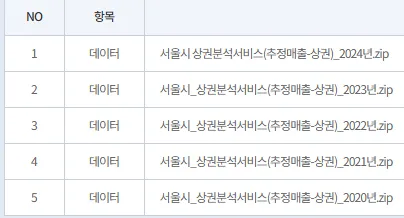

#### 3-1. 원본 데이터 로드 및 통합

- **연도별 파일:**
    
    `서울시_상권분석서비스(추정매출-상권)_2020~2024.csv` 총 5개

    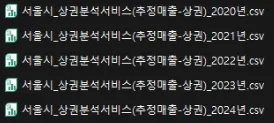
    
    
- `seoul_excel_v4.xlsx` (상권코드 정보) 파일과 병합 ( https://golmok.seoul.go.kr/introduce.do )
    
    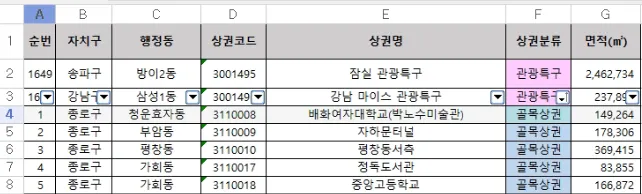
    
- 병합 기준: `상권_코드` (→ `seoul_excel_v4.xlsx`에는 `상권코드`)
- 병합 결과물: `merged_seoul_data_YYYY.csv`로 저장

In [5]:
def preview_seoul_sales_merge(area_excel_path, sales_years):
    area_df = pd.read_excel(area_excel_path, engine='openpyxl')

    for year in sales_years:
        try:
            sales_file = f"서울시_상권분석서비스(추정매출-상권)_{year}년.csv"
            output_file = f"merged_seoul_data_{year}.csv"

            try:
                sales_df = pd.read_csv(sales_file, encoding='utf-8')
            except UnicodeDecodeError:
                sales_df = pd.read_csv(sales_file, encoding='cp949')
            
            merged_df = pd.merge(sales_df, area_df, left_on="상권_코드", right_on="상권코드", how="left")

            merged_df.to_csv(output_file, index=False, encoding='utf-8-sig')

        except Exception as e:
            print(f"{year}년 데이터 처리 중 오류 발생:", e)

# preview_seoul_sales_merge("seoul_excel_v4.xls", [2020, 2021, 2022, 2023, 2024])

#### 3-2. 마포구 데이터 필터링

- 모든 연도 중 **2024년 데이터**(`merged_seoul_data_2024.csv`)에서
    - `"자치구" == "마포구"` 조건으로 필터링
    
    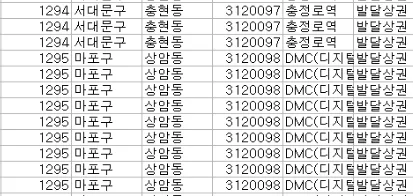
    
    - 👉 마포구 상권만 추출

#### 3-3. 카카오 API keyword 기반 위경도 변환 및 실패 항목 확인

- REST API 키 사용
- 검색어를 이용해 위도(lat), 경도(lng) 값 요청
- `⚠️ 키워드 미매칭:` 로그를 기준으로 **주소 인식 실패 항목 추출**
- 총 4개 항목에서 반복적으로 실패 확인됨:
    - `"서울 마포구 망원2동 KB국민은행 망원동지점"`
    - `"서울 마포구 서교동 홍대부속여중고앞"`
    - `"서울 마포구 상암동 상암동상점가"`
    - `"서울 마포구 서교동 홍대소상공인상점가"`
- 수동으로 경도 위도 매핑
    - 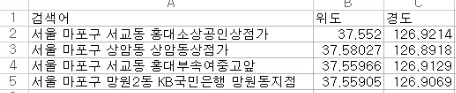


**전처리 데이터 샘플**

| 기준_년분기_코드 | 서비스_업종_코드_명 | 당월_매출_금액 | 당월_매출_건수 | 주중_매출_금액 | 자치구 | 행정동   | 상권명             | 상권분류   | 면적(㎡) | 검색어                                | 위도        | 경도        | 연도 |
|------------------|----------------------|----------------|----------------|----------------|--------|----------|--------------------|------------|-----------|----------------------------------------|-------------|-------------|------|
| 20201           | 한식음식점           | 141590884      | 3612           | 103968582      | 마포구 | 망원1동  | 망원나들목체육관   | 골목상권   | 61616     | 서울 마포구 망원1동 망원나들목체육관 | 37.55275235 | 126.9008185 | 2020 |
| 20201           | 세탁소               | 6875289        | 330            | 4173210        | 마포구 | 망원1동  | 망원나들목체육관   | 골목상권   | 61616     | 서울 마포구 망원1동 망원나들목체육관 | 37.55275235 | 126.9008185 | 2020 |


#### 3-4. 서비스 업종별 가중치 부여

서비스 업종별 가중치를 임의로 정의, 64개의 업종 코드가 있음

| 분류 기준               | 설명                                             | 예시 업종                          |
|-------------------------|--------------------------------------------------|------------------------------------|
| 테이크아웃 중심         | 음식/음료가 포장되어 거리에서 소비됨             | 커피-음료, 제과점, 편의점         |
| 포장재 다량 사용         | 비닐, 일회용 용기 등 포장 쓰레기 다량 배출       | 화장품, 슈퍼마켓, 의약품          |
| 야외 취식 유도           | 음식이 밖에서 소비되기 쉬움                      | 분식전문점, 패스트푸드            |
| 야간 운영 업종           | 심야 시간 길거리 쓰레기 배출량 증가              | 호프-간이주점, 노래방, PC방        |
| 포장 재질이 다양한 업종 | 플라스틱, 종이, 비닐이 섞여 있음                | 제과점, 분식, 패스트푸드           |

업종_코드_종류_총점 샘플 데이터

| 서비스_업종_코드_명 | 개수 | 업종         | 거리소비성 | 포장재다양성 | 야외취식성 | 총점 |
|---------------------|------|--------------|-------------|----------------|--------------|------|
| 한식음식점          | 1293 | 한식음식점   | 2           | 2              | 2            | 6    |
| 커피-음료           | 1143 | 커피-음료    | 3           | 3              | 2            | 8    |
| 미용실              | 999  | 미용실       | 1           | 1              | 0            | 2    |
| 호프-간이주점       | 896  | 호프-간이주점 | 2           | 3              | 3            | 8    |
| 분식전문점          | 811  | 분식전문점   | 3           | 2              | 3            | 8    |

최종 상권 데이터와 업종 코드로 병합 ( **df_merged = pd.merge(df_main, df_score[['업종', '총점']], how='left', left_on='서비스_업종_코드_명', right_on='업종')** )

| 검색어                           | 위도        | 경도        | 연도 | 총점 |
|----------------------------------|-------------|-------------|------|------|
| 서울 마포구 망원1동 망원나들목체육관 | 37.55275235 | 126.9008185 | 2020 | 6    |
| 서울 마포구 망원1동 망원나들목체육관 | 37.55275235 | 126.9008185 | 2020 | 2    |
| 서울 마포구 망원2동 동교초등학교     | 37.55821007 | 126.902355  | 2020 | 6    |


## 4. 마포구 도시공원 정보

- **파일명**: `mapo_park_locations.csv`
- **출처**: 마포구 공공데이터터 ( https://www.mapo.go.kr/site/main/openData/view?dataId=79 )
- **주요 컬럼**: `공원명`, `공원면적`, `위도`, `경도`
- **특징**:
  - **면적 기반 시각화 가능**
  - 야외 취식, 포장 소비가 이루어질 수 있는 공간
  - 면적이나 경도, 위도 값이 조사 예정으로 나와있는 공원 데이터는 분석에서 제외함

## 5. 무단투기 다발 장소

- **파일명**: `	mapo_illegal_dumping_hotspots.csv`
- **출처**: 마포구청 무단투기 집중 순찰지역
- **주요 컬럼**: `주소`, `위도`, `경도`
- **특징**:
  - 민원 기반 데이터로 **문제 지점 파악에 핵심**
  - 동일하게 위치 주소소를 가지고 위도, 경도 변환

## 6. 서울 유동 인구 데이터 (2020~2024)

- **파일명**: `mapo_population_by_hour_2020_2024.csv`
- **출처**: 서울 열린데이터 광장( https://data.seoul.go.kr/dataList/OA-14991/S/1/datasetView.do )
- **주요 컬럼**: `행정동`, `시간대`, `총생활인구수`, `위도`, `경도`
- **특징**:
  - **시간대별 인구 이동 밀도 분석 가능**
  - 쓰레기 수요를 시간/공간적으로 예측하는 데 활용

2020 데이터~ 2024년 데이터까지 ( 48개 x 각 31만개 행 ) 

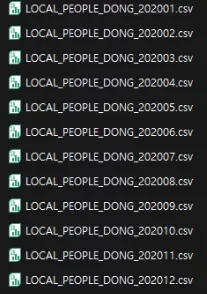

**1. `행정동코드`가 `"11440"`으로 시작하는 마포구 행정동의 데이터만 추출하고 연도별로 정리**

**2. 불필요한 컬럼 제거**

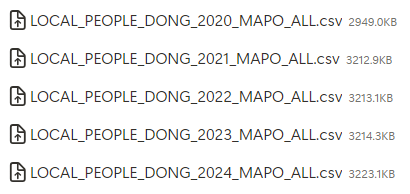

2020년부터 2024년까지의 `LOCAL_PEOPLE_DONG_20XX_MAPO_ALL.csv` 파일들을 기반으로:

**3. **연도별**, **행정동코드별**로**
- 하루 24시간의 생활인구 데이터(`총생활인구수`)에 대해
- `시간별평균생활인구수` (24시간 평균)
- `시간별최대생활인구수` (24시간 중 최대값)
        
        
**4. 각 행정동코드에 대해**
- 행정동 이름(예: 아현동), 위도, 경도 정보를 병합함 (**final_result = pd.merge(result, dong_df, on='행정동코드', how='left')**)

## 7. 마포구 행정동별 연간 쓰레기 배출량

- **파일명**: `mapo_trash_collection_by_dong_2020_2024.csv`
- **출처**: 마포구 공공데이터 ( https://www.mapo.go.kr/site/main/openData/view?dataId=226 )
- **범위**: 2012년 ~ 2022년
- **주요 컬럼**: `행정동`, `총 수거량(kg)`, `연도`
- **특징**:
  - 실제 발생 쓰레기 양을 **정량적 기준**으로 활용
  - 유동 인구, 상권 등 외부 지표와의 비교 가능

## 8. 행정동별 공간 경계 데이터

- **파일명**: `BND_ADM_DONG_PG.zip` + `센서스_공간정보_지역_코드.xlsx`
- **출처**: 디지털트윈 국토 ( https://www.vworld.kr/dtmk/dtmk_ntads_s002.do?dsId=30017 )
- **주요 컬럼**: `ADM_CD`, `ADM_NM`, `geometry`
- **형식**: Shapefile + Excel
- **특징**:
  - **마포구 전체 행정동의 공간 경계 시각화 가능**
  - 생활 인구, 매출, 수거량 등의 데이터를 **지도에 오버레이하기 위한 기본 베이스맵**
  - 행정동 이름(`ADM_NM`) 또는 코드(`ADM_CD`)를 기준으로 **다른 데이터와 병합(merge)** **가능**